In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_model import Unet

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
train_dataset=PlacesDataset(train_files,augment=10,normalize_augment=False, transforms=True)
#train_dataset=data.ConcatDataset((train_dataset_1,train_dataset_2))
val_dataset=PlacesDataset(val_files,augment=10,transforms=True)
indices_test=range(200,500,1)
indices_val=range(0,200)
test_dataset=data.Subset(val_dataset, indices_test)
val_dataset=data.Subset(val_dataset, indices_val)

In [4]:
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1)

In [5]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)
optimizer=Adam(unet.parameters())

cuda


In [6]:
checkpoint = torch.load('model.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.eval()

Unet(
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2b): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Sequential(
    (0): Conv2d(128,

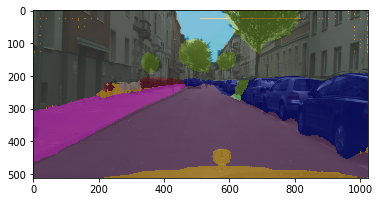

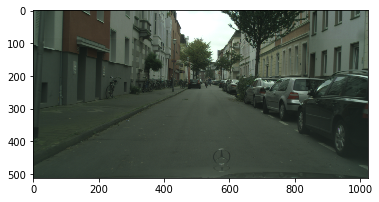

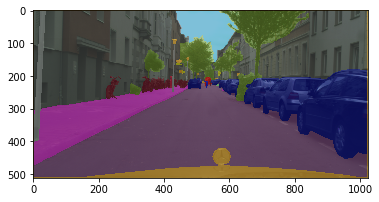

In [48]:
input_image,target=(val_dataset[140])
input_image=input_image.to(device)
target=target.to(device)
with torch.no_grad():
    output_model=unet(input_image.unsqueeze(0))
    n,c,h,w=output_model.size()
    ht,wt=target.size()
    
    if (h!=ht and w!=wt):
        output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)
        
    output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
    output_model=output_model.squeeze(0).cpu().numpy()
    predicted=np.argmax(output_model,axis=2)
    #predicted[predicted==19]=250
plt.imshow(train_dataset.decode_segmap(predicted), cmap='gray')
plt.imshow(input_image.cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
plt.show()
plt.imshow(input_image.cpu().numpy().transpose(1,2,0)[:,:,::-1])
plt.show()
plt.imshow(train_dataset.decode_segmap(target.cpu().numpy()), cmap='gray')
plt.imshow(input_image.cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
plt.show()